Загружаем необходимые данные

In [1]:
!pip install transformers

In [2]:
!pip install tensorflow

In [3]:
!pip install scikit-learn

In [4]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback,
                          AdamW,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2023-02-20 00:58:31.754524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 00:58:31.928868: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 00:58:32.626217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 00:58:32.626306: W tensorflow/

In [5]:
device = 'cuda'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [6]:
!pip install chardet

In [7]:
import chardet
with open('2 STEP (название).csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}

In [8]:
df = pd.read_csv('2 STEP (название).csv', encoding='UTF-8-SIG', sep=';')
# Размер нашей выборки
df.shape

(105000, 3)

In [9]:
df.sample(5)

,Unnamed: 0,name,category_1
52633,61599,Мужчину с молотком обезвредили в мечети возле ...,Происшествия
67647,31494,Посмеявшихся над зарплатами сотрудниц роддома ...,Общество
8966,40045,Боевики ИГ опубликовали интервью с захваченным...,Общество
101789,82520,Чубайс отказался считать фатальным отсутствие ...,Госэкономика
56675,30515,Названа цена расселения пострадавшего от взрыв...,Общество


In [10]:
df.category_1.unique()

array(['Все', 'Украина', 'Футбол', 'Общество', 'Политика', 'Происшествия',
       'Госэкономика'], dtype=object)

In [11]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [12]:
category_index

{'Все': 0,
 'Украина': 1,
 'Футбол': 2,
 'Общество': 3,
 'Политика': 4,
 'Происшествия': 5,
 'Госэкономика': 6}

In [13]:
category_index_reverce

{0: 'Все',
 1: 'Украина',
 2: 'Футбол',
 3: 'Общество',
 4: 'Политика',
 5: 'Происшествия',
 6: 'Госэкономика'}

In [14]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [15]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

(' а пять лет спустя был избран на второй срок. На посту президента в 2005 году его сменил Сергей Багапш. В ходе грузино-абхазского вооруженного конфликта Ардзинба руководил государственным комитетом обороны. Пост президента он занял в 1994 году',
 0)

In [16]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [17]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [18]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [19]:
len(train_sentences), len(test_sentences)

(104475, 525)

In [42]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [44]:
# Посмотрим, что получилось
print(tokenized_texts[42])

['[CLS]', 'fitch', 'п', '##о', '##д', '##т', '##в', '##е', '##р', '##д', '##и', '##л', '##о', 'р', '##е', '##и', '##т', '##и', '##н', '##г', 'р', '##о', '##с', '##с', '##ии', 'н', '##а', 'и', '##н', '##в', '##е', '##с', '##т', '##и', '##ц', '##и', '##о', '##н', '##н', '##о', '##м', 'у', '##р', '##ов', '##н', '##е', '[SEP]']


In [45]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([1.8885e+04, 8.5358e+04, 1.3000e+02, 4.5000e+01, 2.2000e+01,
        1.6000e+01, 6.0000e+00, 8.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([  5. ,  39.2,  73.4, 107.6, 141.8, 176. , 210.2, 244.4, 278.6,
        312.8, 347. ]),
 <BarContainer object of 10 artists>)

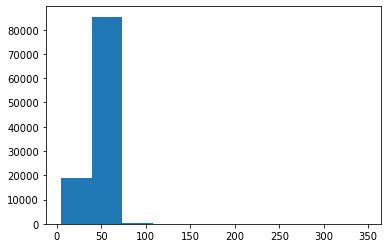

In [46]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [47]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [48]:

# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]
     

array([  101, 26062,  1194, 14150, 29742, 22919, 25529, 15290, 16856,
       29742, 10325, 29436, 14150,  1195, 15290, 10325, 22919, 10325,
       18947, 29741,  1195, 14150, 29747, 29747])

In [49]:

# Создадим маску внимания для каждого сэмпла обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [50]:

print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [51]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [52]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [53]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [54]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [55]:
from torch.utils.data import SequentialSampler

In [56]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

In [57]:
config = AutoConfig.from_pretrained("bert-base-uncased",
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [58]:
#Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [59]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [60]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [61]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/srv/conda/envs/saturn/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [63]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 1.4789659759625287
CPU times: user 4min 45s, sys: 1min 49s, total: 6min 34s
Wall time: 6min 34s


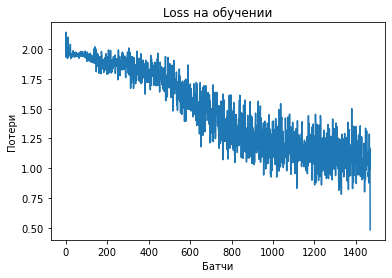

In [64]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [65]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [66]:
print(classification_report(valid_labels, valid_preds, target_names=['Все', 'Политика', 'Общество', 'Украина', 'Происшествия',
       'Госэкономика', 'Футбол']))

              precision    recall  f1-score   support

         Все       0.76      0.55      0.64      1489
    Политика       0.65      0.79      0.71      1490
    Общество       0.88      0.79      0.83      1495
     Украина       0.43      0.40      0.41      1506
Происшествия       0.58      0.59      0.58      1479
Госэкономика       0.52      0.70      0.59      1525
      Футбол       0.68      0.57      0.62      1464

    accuracy                           0.63     10448
   macro avg       0.64      0.63      0.63     10448
weighted avg       0.64      0.63      0.63     10448



Сохранение и загрузка дообученной модели

In [67]:
model.save_pretrained('Bert')
tokenizer.save_pretrained('Bert')

('Bert/tokenizer_config.json',
 'Bert/special_tokens_map.json',
 'Bert/vocab.txt',
 'Bert/added_tokens.json')

In [68]:
# config
config = AutoConfig.from_pretrained('Bert')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('Bert', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('Bert', config=config)

In [69]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [70]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Название статьи: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()

Название статьи: В Великобритании рассекретили план похищения королевы Виктории
Предсказанная категория: Происшествия
Истинная категория: Общество

Название статьи: Савченко приехала в Донбасс и села за штурвал боевого вертолета
Предсказанная категория: Украина
Истинная категория: Украина

Название статьи: Именинница съела обед в самолете и пролежала три дня с отравлением
Предсказанная категория: Происшествия
Истинная категория: Происшествия

Название статьи: Вице-президент США назвал республиканцев неандертальцами
Предсказанная категория: Политика
Истинная категория: Политика

Название статьи: Радамель Фалькао перейдет в клуб российского бизнесмена
Предсказанная категория: Футбол
Истинная категория: Футбол

Название статьи: Министр экономики Швейцарии осудил санкции против России
Предсказанная категория: Госэкономика
Истинная категория: Политика

Название статьи: Минобразования Киргизии засудило противников школьной формы
Предсказанная категория: Все
Истинная категория: Все

Название 